In [2]:
from glob import glob

%matplotlib inline
from pylab import *
# import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

import rasterio

# add the unet helpers
sys.path.append('../../')
from test_unet_helpers import *
from unet_models import unet11_MS

# torch stuff
import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models, datasets
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expe

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

from glob import glob
class DG_GT_Dataset(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, data_dir, channels='all', img_transform=None, gt_transform=None):
        """ 
        Args:
            data_dir (string): the folder containing the image files
            channels (string): 'all', 'bgr', 'bgrn1', 'bgrn2'; band sets for DG imagery
            img_transform (callable, optional): Optional transform to  be applied to source image data
            gt_transform (callable, optional): Optional transform to  be applied to labeled image data
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.gt_files = sorted(glob(data_dir + '/gt*.tif'))
        self.img_files = sorted(glob(data_dir + '/dg*.tif'))
        
        
        print(self.img_files[0])
        print(self.gt_files[0])
        
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.dg_bgr = [1,2,4]
        self.dg_bgrn1 = [1,2,4,6]
        self.dg_bgrn2 = [1,2,4,7]
        self.channels = channels
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        # check the channels
        if self.channels == 'bgr':
            img_arr = img_arr[self.dg_bgr, :, :]
        elif self.channels == 'bgrn1':
            img_arr = img_arr[self.dg_bgrn1, :, :]
        elif self.channels == 'bgrn2':
            img_arr = img_arr[self.dg_brgn2, :, :]
        else:
            pass
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()

        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
        
        
    def __len__(self):
        return len(self.img_files)

# Now that data is ready, set up the model and run through it

## some code for setting up the model and performance eval

In [4]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# DO the same for pansharpened data

In [5]:
train_folder = r'D:\projects\RD\debug_IS_segmentation\tilesPS_d10000_512x512\train'
test_folder = r'D:\projects\RD\debug_IS_segmentation\tilesPS_d10000_512x512\test'
val_folder = r'D:\projects\RD\debug_IS_segmentation\tilesPS_d10000_512x512\val'

# ubuntu paths
train_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tilesPS_d10000_512x512/train'
test_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tilesPS_d10000_512x512/test'
val_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tilesPS_d10000_512x512/val'

# aws pathts
train_folder = '../../../tiles/kmeans3_split/tilesPS_d10000_512x512/train'
test_folder = '../../../tiles/kmeans3_split/tilesPS_d10000_512x512/test'
val_folder = '../../../tiles/kmeans3_split/tilesPS_d10000_512x512/val'

# load as 4 band
ps_train_ds = DG_GT_Dataset(train_folder, channels='bgrn1')
ps_test_ds = DG_GT_Dataset(test_folder, channels='bgrn1')
ps_val_ds = DG_GT_Dataset(val_folder, channels='bgrn1')

../../../tiles/kmeans3_split/tilesPS_d10000_512x512/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tilesPS_d10000_512x512/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tilesPS_d10000_512x512/test/dg_is_00731.tif
../../../tiles/kmeans3_split/tilesPS_d10000_512x512/test/gt_is_00731.tif
../../../tiles/kmeans3_split/tilesPS_d10000_512x512/val/dg_is_00500.tif
../../../tiles/kmeans3_split/tilesPS_d10000_512x512/val/gt_is_00500.tif


In [6]:
# RGB-NIR
model_path = './files_PS_bgrn1/bgrn1_ps_ep75_step1575_b24.pt'

torch.cuda.empty_cache()

#model = unet11(pretrained=False) # B-G-R
ps_model = unet11_MS(num_bands=4, pretrained=False) 


# load on CPU
if os.path.exists(model_path):
    state_dict = torch.load(str(model_path), map_location='cpu')
    epoch = state_dict['epoch']
    step = state_dict['step']
    new_state_dict = OrderedDict()
    for k, v in state_dict['model'].items():
        name = k[7:] # remove 'module.' of dataparallel
        new_state_dict[name]=v

    ps_model.load_state_dict(new_state_dict)
    print('Restored model, epoch {}, step {:,}'.format(epoch, step))

ps_model.eval()

num_bands is  4
Restored model, epoch files_PS_bgrn1/bgrn1_ps_ep75_step1575_b24.pt, step 1,575


UNet11_MS(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplac

In [7]:
all_tps = []
all_fps= []
maxes = []
mins = []
aucs = []
for ind in range(len(ps_val_ds)):
    test_im, test_target = ps_val_ds[ind]
    test_out = ps_model(variable(test_im.unsqueeze(0)))
    

    out = test_out.cpu().detach().numpy()[0][0]
    maxes.append(out.max())
    mins.append(out.min())
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target.numpy().flatten(), out.flatten())
    aucs.append(roc_auc_score(test_target.numpy().flatten(), out.flatten()))
    all_tps.append(true_positive_rate)
    all_fps.append(false_positive_rate)

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


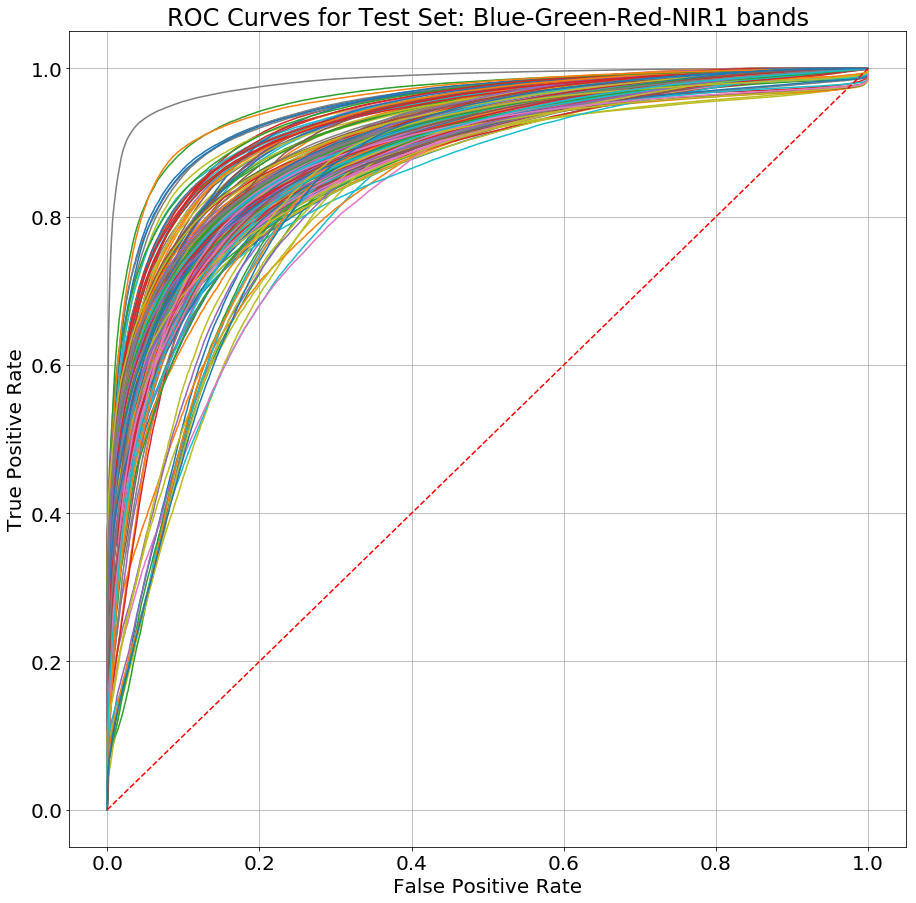

In [8]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)


plt.figure(figsize=(15,15))
for i in range(len(all_tps)):
    
    plt.plot(all_fps[i], all_tps[i])
    
plt.plot([0,1], [0,1], 'r--')
plt.title('ROC Curves for Test Set: Blue-Green-Red-NIR1 bands')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [9]:
max(maxes), min(mins)

(205.22368, -140.96399)

In [10]:
rasters = glob('./rastertiles2015/*.tif')
rasmax2, rasmin2 = [], []
for f in rasters:
    with rio.open(f) as src:
        arr = src.read()
        rasmax2.append(arr.max())
        rasmin2.append(arr.min())
        
rasters2 = glob('./rastertiles2/*.tif')
rasmax, rasmin = [], []
for f in rasters2:
    with rio.open(f) as src:
        arr = src.read()
        rasmax.append(arr.max())
        rasmin.append(arr.min())

In [11]:
max(rasmax2), min(rasmin2)

(140.80807495117188, -183.5094757080078)

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


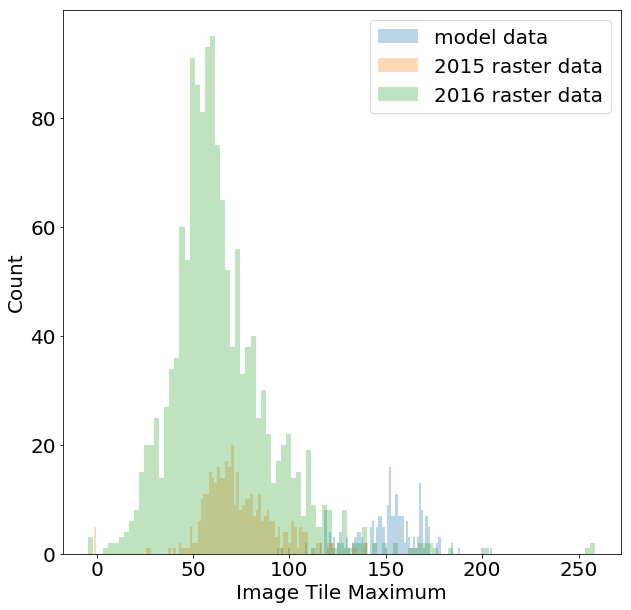

In [12]:
plt.figure(figsize=(10,10))
plt.hist(maxes, alpha=0.3, bins=100, label='model data')
plt.hist(rasmax2, alpha=0.3, bins=100, label='2015 raster data')
plt.hist(rasmax, alpha=0.3, bins=100, label='2016 raster data')
plt.legend()
plt.xlabel('Image Tile Maximum')
plt.ylabel('Count')
plt.show()

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


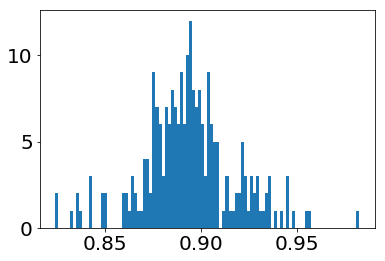

In [13]:
plt.hist(aucs, bins=100);

In [16]:
mean(aucs), min(aucs), max(aucs)

(0.8938156332419092, 0.8241554902374686, 0.9827058565049853)